Input 0: HAM10000 train images
Input 1: ISIC2016 train images
Combined images: HAM10000 train images AND ISIC2016 train images AND 
Input 0: HAM10000 test images
Input 1: ISIC2016 test images
Combined images: HAM10000 test images AND ISIC2016 test images AND 
Input 0: HAM10000 validation images
Input 1: ISIC2016 validation images
Combined images: HAM10000 validation images AND ISIC2016 validation images AND 
Input: 0: HAM10000 train labels
Input: 1: ISIC2016 train labels
Combined labels: HAM10000 train labels AND ISIC2016 train labels AND 
Input: 0: HAM10000 test labels
Input: 1: ISIC2016 test labels
Combined labels: HAM10000 test labels AND ISIC2016 test labels AND 
Input: 0: HAM10000 validation labels
Input: 1: ISIC2016 validation labels
Combined labels: HAM10000 validation labels AND ISIC2016 validation labels AND 


/home/sanghyuk.kim001/anaconda3/envs/clean_chimera_env/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Building HAM10000 + ISIC2016 binary training on ResNet50 model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 23,850,242
Trainable params: 262,530
Non-trainable params: 23,587,712
_________________________________________________________________
None


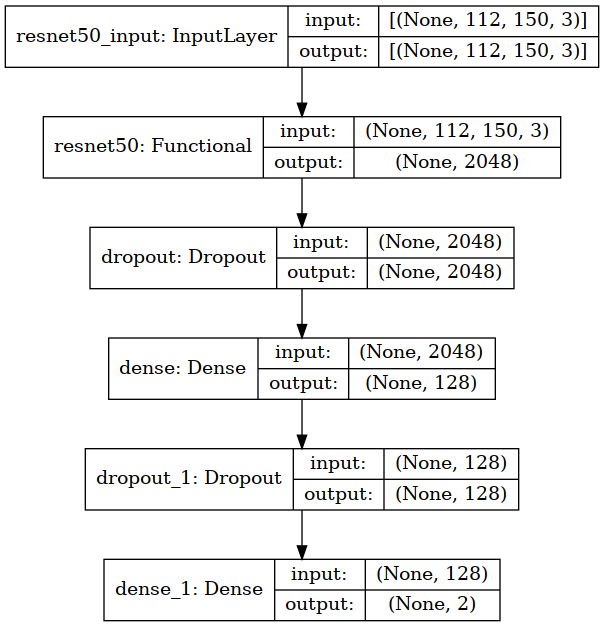

In [9]:
import melanoma as mel

%matplotlib inline
%load_ext autoreload
%autoreload -p 2

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

rootpath = '/hpcstor6/scratch01/s/sanghyuk.kim001'
img_size = (112, 150) # height, width
utilInstance = mel.Util(rootpath, img_size)
dataType = mel.DatasetType.ISIC2017


DEBUG = 0
# Save datasets as pickle files
if (DEBUG == 1):
    utilInstance.saveDatasetsToFile(dataType)

dbpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB'

trainimages_HAM10000, testimages_HAM10000, validationimages_HAM10000, \
			trainlabels_binary_HAM10000, testlabels_binary_HAM10000, validationlabels_binary_HAM10000, num_classes_binary_HAM10000\
                 = utilInstance.loadDatasetFromFile(dbpath+'/'+f'HAM10000_{img_size[0]}h_{img_size[1]}w_binary.pkl')
trainimages_ISIC2016, testimages_ISIC2016, validationimages_ISIC2016, \
			trainlabels_binary_ISIC2016, testlabels_binary_ISIC2016, validationlabels_binary_ISIC2016, num_classes_binary_ISIC2016\
                 = utilInstance.loadDatasetFromFile(dbpath+'/'+f'ISIC2016_{img_size[0]}h_{img_size[1]}w_binary.pkl')
trainimages_ISIC2017, testimages_ISIC2017, validationimages_ISIC2017, \
			trainlabels_binary_ISIC2017, testlabels_binary_ISIC2017, validationlabels_binary_ISIC2017, num_classes_binary_ISIC2017\
                 = utilInstance.loadDatasetFromFile(dbpath+'/'+f'ISIC2017_{img_size[0]}h_{img_size[1]}w_binary.pkl')

# Now, let's combine HAM10000 and ISIC2016 DBs
trainimages_combination = {"HAM10000 train images":trainimages_HAM10000, "ISIC2016 train images":trainimages_ISIC2016}
testimages_combination = {"HAM10000 test images":testimages_HAM10000, "ISIC2016 test images":testimages_ISIC2016}
validationimages_combination = {"HAM10000 validation images":validationimages_HAM10000, "ISIC2016 validation images":validationimages_ISIC2016}
trainlabels_combination = {"HAM10000 train labels":trainlabels_binary_HAM10000, "ISIC2016 train labels":trainlabels_binary_ISIC2016}
testlabels_combination = {"HAM10000 test labels":testlabels_binary_HAM10000, "ISIC2016 test labels":testlabels_binary_ISIC2016}
validationlabels_combination = {"HAM10000 validation labels":validationlabels_binary_HAM10000, "ISIC2016 validation labels":validationlabels_binary_ISIC2016}

trainimages_HAM10000_ISIC2016 = utilInstance.combine_images(**trainimages_combination)
testimages_HAM10000_ISIC2016 = utilInstance.combine_images(**testimages_combination)
validationimages_HAM10000_ISIC2016 = utilInstance.combine_images(**validationimages_combination)
trainlabels_binary_HAM10000_ISIC2016 = utilInstance.combine_labels(**trainlabels_combination)
testlabels_binary_HAM10000_ISIC2016 = utilInstance.combine_labels(**testlabels_combination)
validationlabels_binary_HAM10000_ISIC2016 = utilInstance.combine_labels(**validationlabels_combination)

img_height, img_width = utilInstance.getImgSize()
CFG = dict(
			batch_size            =  20,   # 8; 16; 32; 64; bigger batch size => moemry allocation issue
			epochs                =  30,   # 5; 10; 20;
			last_trainable_layers =   0,
			verbose               =   1,   # 0; 1
			fontsize              =  14,
			num_classes           =  2, # binary

			# Images sizes
			img_height = img_height,   # Original: (450h, 600w)
            img_width = img_width,

			# Images augs
			ROTATION_RANGE        =  90.0,
			ZOOM_RANGE            =   0.1,
			HSHIFT_RANGE          =   0.1, # randomly shift images horizontally
			WSHIFT_RANGE          =   0.1, # randomly shift images vertically
			HFLIP                 = False, # randomly flip images
			VFLIP                 = False, # randomly flip images

			# Postprocessing
			stopper_patience      =  10,   # 0.01; 0.05; 0.1; 0.2;
			run_functions_eagerly = False,
            
            # save
            snapshot_path = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot'
		)

# HAM10000 + ISIC2016 binary training

base_model_binary = mel.CNN(trainimages_HAM10000_ISIC2016, trainlabels_binary_HAM10000_ISIC2016, \
    validationimages_HAM10000_ISIC2016, validationlabels_binary_HAM10000_ISIC2016, \
        testimages_HAM10000_ISIC2016, testlabels_binary_HAM10000_ISIC2016, CFG)
ResNet50_name = 'HAM10000 + ISIC2016 binary training on ResNet50'
data_gen_HAM10000_ISIC2016, Resnet50_model = base_model_binary.resnet50(ResNet50_name)

# Install the below beforehand
# pip install pydot
# conda install -c anaconda graphviz
visualizer = mel.Visualizer()
visualizer.visualize_model(model = Resnet50_model, model_name = ResNet50_name)



In [ ]:
history_HAM10000_ISIC2016_bin = base_model_binary.fit_model(    
    model = Resnet50_model,
    model_name = ResNet50_name,
    trainimages = trainimages_HAM10000_ISIC2016,
    trainlabels = trainlabels_binary_HAM10000_ISIC2016,
    validationimages = validationimages_HAM10000_ISIC2016,
    validationlabels = validationlabels_binary_HAM10000_ISIC2016,
    data_gen = data_gen_HAM10000_ISIC2016
)

visualizer.visualize_performance(
    model_name = ResNet50_name,
    history = history_HAM10000_ISIC2016_bin
)

In [13]:
from keras.models import load_model
# modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/'
filename = 'HAM10000_ISIC2016_binary_ResNet50.hdf5'
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename
# saved_model = load_model(modelpath)


# Since model is traiined using HAM10000+ISIC2016, test set should be using only ISIC2016 or ISIC2017 test sets
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'HAM10000 + ISIC2016 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2016,
    trainlabels = trainlabels_binary_ISIC2016,
    validationimages = validationimages_ISIC2016,
    validationlabels = validationlabels_binary_ISIC2016,
    testimages = testimages_ISIC2016,
    testlabels = testlabels_binary_ISIC2016
)

# Test on ISIC2017 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'HAM10000 + ISIC2016 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2017,
    trainlabels = trainlabels_binary_ISIC2017,
    validationimages = validationimages_ISIC2017,
    validationlabels = validationlabels_binary_ISIC2017,
    testimages = testimages_ISIC2017,
    testlabels = testlabels_binary_ISIC2017
)


Evaluating HAM10000 + ISIC2016 binary ResNet50 model...

23/23 [==============================] - 5s 193ms/step - loss: 0.4928 - accuracy: 0.8136
Train loss = 0.4928126335144043  ;  Train accuracy = 81.36%

6/6 [==============================] - 1s 200ms/step - loss: 0.4381 - accuracy: 0.8389
Validation loss = 0.43814215064048767  ;  Validation accuracy = 83.89%

12/12 [==============================] - 2s 184ms/step - loss: 0.4782 - accuracy: 0.8148
Test loss = 0.47822925448417664  ;  Test accuracy = 81.48%
Evaluating HAM10000 + ISIC2016 binary ResNet50 model...

63/63 [==============================] - 13s 192ms/step - loss: 0.5203 - accuracy: 0.8195
Train loss = 0.520298421382904  ;  Train accuracy = 81.95%

5/5 [==============================] - 1s 191ms/step - loss: 0.5698 - accuracy: 0.8000
Validation loss = 0.5698150396347046  ;  Validation accuracy = 80.00%

19/19 [==============================] - 4s 207ms/step - loss: 0.6077 - accuracy: 0.8050
Test loss = 0.6077184081077576  